## Active inference for mobile robot navigation

Wouter Kouw, last update: 02-05-2024

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations: polar coordinates from beacon

In the middle of a training area, there is a beacon that reports range and angle to the robot. This will allow it to infer its position in the field through a polar-to-cartesian transformation:

$$\begin{align}
y_{1,k} &= g_1(z_k) = \sqrt{x_{1,k}^2 + x_{2,k}^2} \\
y_{2,k} &= g_2(z_k) = \mathrm{atan}(x_{1,k}, x_{2,k}) \, ,
\end{align}$$

where $\mathrm{atan}$ refers to the arctangent. We denote this as:

$$y_k = g(z_k) + r_k$$

where $r_k$ is measurement noise. We can simulate the behaviour of this system as follows:

In [243]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity`


In [244]:
using Colors
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using StatsPlots
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=15Plots.pt)
include("util.jl");

In [245]:
# Time
Δt = 0.1
len_time = 10
tsteps = range(0, step=Δt, length=len_time)

0.0:0.1:0.9

In [246]:
# Dynamics

# Matrices
A = [1. 0. Δt 0.;
     0. 1. 0. Δt;
     0. 0. 1. 0.;
     0. 0. 0. 1.]
B = [0. 0.;
     0. 0.;
     Δt 0.;
     0. Δt]

# Process noise
ρ_1 = 1e-3
ρ_2 = 1e-3
Q = [Δt^3/3*ρ_1          0.0  Δt^2/2*ρ_1          0.0;
             0.0  Δt^3/3*ρ_2          0.0  Δt^2/2*ρ_2;
     Δt^2/2*ρ_1          0.0      Δt*ρ_1          0.0;
             0.0  Δt^2/2*ρ_2          0.0      Δt*ρ_2]

4×4 Matrix{Float64}:
 3.33333e-7  0.0         5.0e-6  0.0
 0.0         3.33333e-7  0.0     5.0e-6
 5.0e-6      0.0         0.0001  0.0
 0.0         5.0e-6      0.0     0.0001

In [247]:
# Observations

# Nonlinear observation
g(x::AbstractVector) = [sqrt(x[1]^2 + x[2]^2), atan(x[2],x[1])]

# Measurement noise
R = 1e-1*diagm(ones(2));

In [248]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = rand(MvNormal(A*z_kmin1 + B*u_k, Q))
    
    # Emit noisy observation
    y_k = rand(MvNormal(g(z_k), R))
    
    return y_k, z_k
end;

In [249]:
# Setpoint (desired observation)
z_star = [.5, .5, 0.0, 0.0]
y_star = g(z_star)

2-element Vector{Float64}:
 0.7071067811865476
 0.7853981633974483

In [250]:
# Initial state
z_0 = [-.5, -.5, 0.0, 0.0]

# Preallocate
z = zeros(4,len_time)
y = zeros(2,len_time)
u = zeros(2,len_time)

# Start recursion
u_kmin1 = zeros(2)
z_kmin1 = z_0
for k in 1:len_time

    # Generate control
    u[:,k] = u_kmin1 + 2randn(2)
    
    # Update system
    y[:,k], z[:,k] = update(z_kmin1, u[:,k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    u_kmin1 = u[:,k]
    
end

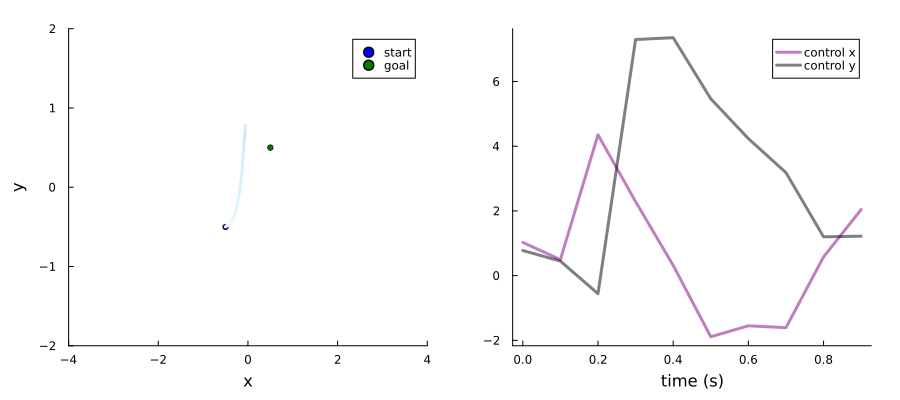

In [251]:
p1 = scatter([z[1,1]], [z[2,1]], c="blue", xlabel="x", ylabel="y", xlims=(-4, 4), ylims=(-2, 2), label="start")
plot!(z[1,:], z[2,:], c=colormap("Blues")[range(1, step=2, length=len_time)])
scatter!([z_star[1]], [z_star[2]], color="green", label="goal", markersize=3)
p2 = plot(tsteps, u[1,:], color="purple", xlabel="time (s)", alpha=0.5, label="control x")
plot!(tsteps, u[2,:], color="black", xlabel="time (s)", alpha=0.5, label="control y")

plot(p1, p2, layout=(1,2), size=(900,400))

### Probabilistic model

The above system can be captured with a probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

### Model evidence

$$\begin{align}
p(y_k \mid y_{1:k-1}) &= \int p(y_k \mid z_k) p(z_k \mid y_{1:k-1}) dz_k \\
&= \int \mathcal{N} \big(\begin{bmatrix} z_k \\ y_k \end{bmatrix} \mid \begin{bmatrix} m_k \\ \mu_k \end{bmatrix}, \begin{bmatrix} S_k & \Gamma_k \\ \Gamma_k^{\top} & \Sigma_k \end{bmatrix} \big) dz_k \\
&= \mathcal{N}(y_k \mid \mu_k, \Sigma_k)
\end{align}$$

In [252]:
function evidence(y,m,S)
    "Marginal likelihood"
    μ, Σ, Γ = ET2(m, S, g, addmatrix=R, forceHermitian=true)
    return pdf(MvNormal(μ, Matrix(Σ)), y)
end

evidence (generic function with 1 method)

### Planning and control

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{aligned}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{aligned}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{aligned}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(s|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{aligned}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{aligned}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{aligned}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{aligned}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{aligned}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi R - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{aligned}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{aligned}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{aligned}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{aligned}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

The above equations can be written down to form an objective function.

In [253]:
function ambiguity(Σ,Γ,S)
   return 0.5*logdet(Σ - Γ'*inv(S)*Γ)
end

ambiguity (generic function with 1 method)

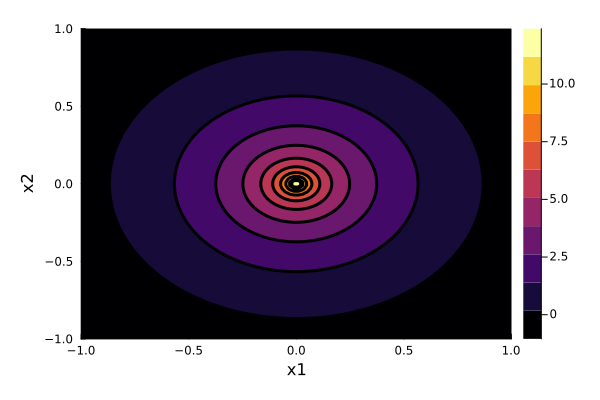

In [254]:
function helper(x,y; S_t=diagm(ones(2)))

    # Unscented transform moments
    mE, SE, CE = ET2([x; y], S_t, g, addmatrix=R, forceHermitian=true)

    # Calculate ambiguity
    return 1/2*logdet(SE-CE'*inv(S_t)*CE)

end

xr = range(-1, stop=1, length=100)
yr = range(-1, stop=1, length=100)
contourf(xr,yr, (xr,yr) -> helper(xr,yr), nlevels=10, xlabel="x1", ylabel="x2")

In [255]:
savefig("figures/cart2polar-ambiguity-contourf.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/cart2polar-ambiguity-contourf.png"

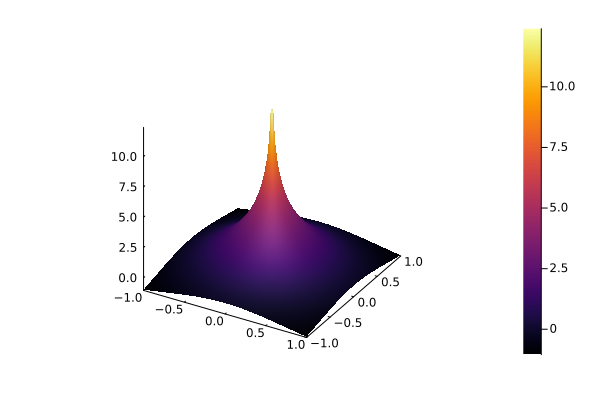

In [256]:
surface(xr,yr, (xr,yr) -> helper(xr,yr))

In [257]:
savefig("figures/cart2polar-ambiguity-surf.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/cart2polar-ambiguity-surf.png"

In [258]:
# function risk(μ, Σ, goal)
#     "Naive version"
#     m_star, S_star = goal
#     iS = inv(S_star)
#     return 0.5(log(det(S_star)/det(Σ)) + length(m_star) + (μ-m_star)'*iS*(μ-m_star) + tr(iS*Σ))
# end

function risk(μ, Σ, goal)
    "Numerically improved version"
    
    m_star, S_star = goal
    k = length(m_star)
    
    L0 = cholesky(Σ).L
    L1 = cholesky(S_star).L
    
    M = inv(L1)*L0
    y = inv(L1)*(m_star - μ)
    
    return 0.5(sum(M[:].^2) - k + norm(y,1).^2 + 2*sum([log(L1[i,i]./L0[i,i]) for i in 1:k]))
end

risk (generic function with 1 method)

In [259]:
function EFE(u::AbstractVector, 
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Tuple{Vector{Float64}, Matrix{Float64}}; 
             η_u::Float64=1.0,
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[(t-1)*2+1:2t]
        S_t = A*S_tmin1*A' + Q

        # Unscented transform moments
        μ, Σ, Γ = ET2(m_t, S_t, g, addmatrix=R, forceHermitian=true)
        
        # Cumulate EFE
        cEFE += risk(μ,Σ, goal) + ambiguity(Σ,Γ, S_t) + η_u*u[(t-1)*2+1:2t]'*u[(t-1)*2+1:2t]
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

EFE (generic function with 1 method)

We can use the Optim.jl library to auto-differentiate EFE and minimize it every time step.

In [260]:
len_trial = 30
tsteps = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 3;

In [261]:
# Distribution around goal state
goal = (g(z_star), 0.1diagm(ones(2)))

# Limits of controller
u_lims = (-5.0, 5.0)
opts = Optim.Options(time_limit=20)
η_u = 0.0

# Preallocate
z_est = (zeros(4,len_trial), zeros(4,4,len_trial))
z_sim = zeros(4,len_trial)
y_sim = zeros(2,len_trial)
u_sim = zeros(2,len_trial)
F = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Initial belief
m_0 = z_0
S_0 = 1e-3diagm(ones(4))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

# Initialize policy
policy = zeros(2len_horizon)

μ = zeros(2)  
Σ = zeros(2,2)
Γ = zeros(2,4)

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[:,k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[:,k-1]
    S_k_pred = A*S_kmin1*A' .+ Q
    
    # Correction step
    μ, Σ, Γ = ET2(m_k_pred, S_k_pred, g, addmatrix=R, forceHermitian=true)
    m_k = m_k_pred .+ Γ*inv(Σ)*(y_sim[:,k] - μ)
    S_k = S_k_pred .- Γ*inv(Σ)*Γ'
    
    # Compute model evidence
    F[k] = evidence(y_sim[:,k], m_k, S_k)
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, (m_k,S_k), goal, η_u=η_u, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(2*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    # results = Optim.optimize(G, zeros(2*len_horizon), LBFGS(), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = Optim.minimizer(results)
    u_sim[:,k] = policy[1:2]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


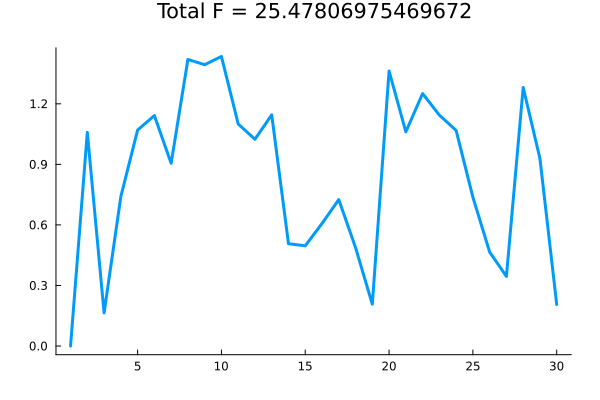

In [262]:
tF = sum(F)
plot(F, title="Total F = $tF")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/experiment-EFE-path.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/experiment-EFE-path.gif")
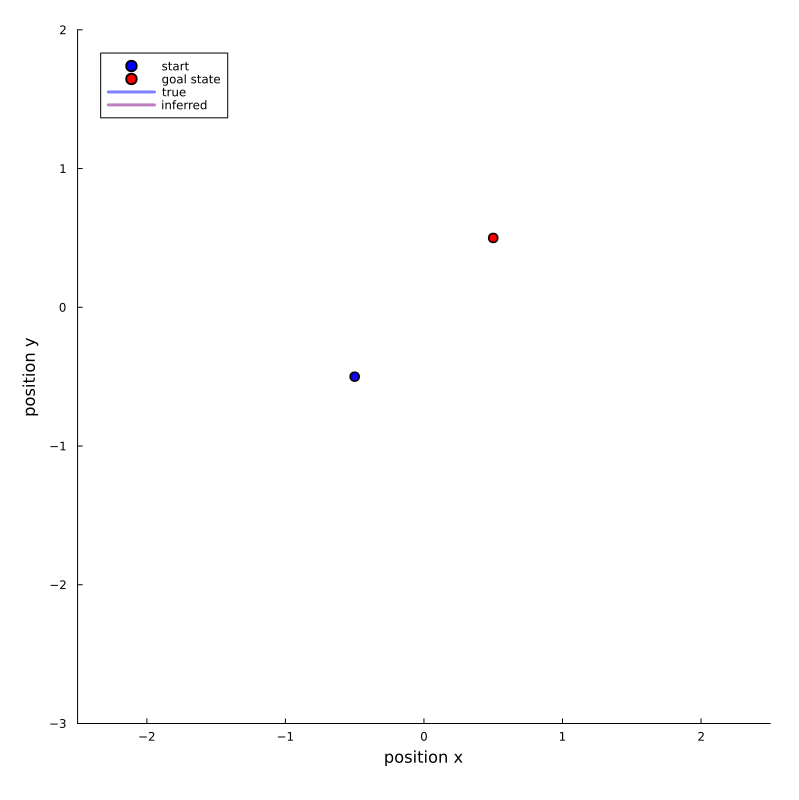

In [263]:
anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), aspect_ratio=:equal, legend=:topleft, ylabel="position y", xlabel="position x", xlims=(-2.5, 2.5), ylims=(-3.0, 2.0))
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", alpha=0.5, label="true")
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], ribbon=[det(z_est[2][1:2,1:2,j]) for j = 2:k], c="purple", alpha=0.5, label="inferred")
end
gif(anim, "figures/experiment-EFE-path.gif", fps=3) 

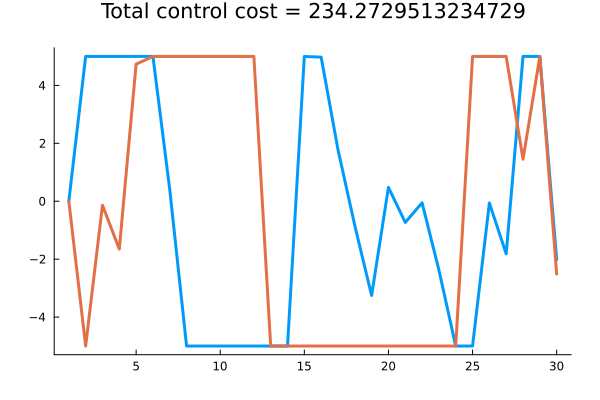

In [264]:
tU = sum(abs.(u_sim[:]))
plot(u_sim', title="Total control cost = $tU")

### Visualize planned trajectory

In [265]:
function planned_trajectory(policy, current_state; time_horizon=1)
    "Generate future states and observations"
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = current_state
    
    # Track predicted observations
    z_m = zeros(4,  time_horizon)
    z_S = zeros(4,4,time_horizon)
    y_m = zeros(2,  time_horizon)
    y_S = zeros(2,2,time_horizon)
    
    for t in 1:time_horizon
        
        # State transition
        z_m[:,t] = A*m_tmin1 + B*policy[:,t]
        z_S[:,:,t] = A*S_tmin1*A' + Q
        
        # Predicted observations
        y_m[:,t], y_S[:,:,t] = ET2(z_m[:,t], z_S[:,:,t], g, addmatrix=R)
        
        # Update previous state
        m_tmin1 = z_m[:,t]
        S_tmin1 = z_S[:,:,t]
        
    end
    return (z_m, z_S), (y_m, y_S)
end

planned_trajectory (generic function with 1 method)

In [266]:
# Preallocate
z_est = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim = zeros(4,len_trial)
y_sim = zeros(2,len_trial)
u_sim = zeros(2,len_trial)
F = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
z_kmin1 = z_0

μ = []
Σ = []
Γ = []

policy = zeros(2*len_horizon)

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[:,k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[:,k-1]
    S_k_pred = A*S_kmin1*A' .+ Q

    # Correction step
    μ, Σ, Γ = ET2(m_k_pred, S_k_pred, g, addmatrix=R, forceHermitian=true)
    m_k = m_k_pred .+ Γ*inv(Σ)*(y_sim[:,k] - μ)
    S_k = S_k_pred .- Γ*inv(Σ)*Γ'
    
    # Compute model evidence
    F[k] = -log(evidence(y_sim[:,k], m_k, S_k))
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, (m_k,S_k), goal, η_u=η_u, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(2*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    # results = Optim.optimize(G, zeros(2*len_horizon), LBFGS(), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = reshape(Optim.minimizer(results), (2,len_horizon))
    
    # Planning
    planned_states, planned_obs = planned_trajectory(policy, (m_k,S_k), time_horizon=len_horizon)
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
    
    # Execute first planned action only
    u_sim[:,k] = policy[:,1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/experiment-EFE-path+planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/experiment-EFE-path+planning.gif")
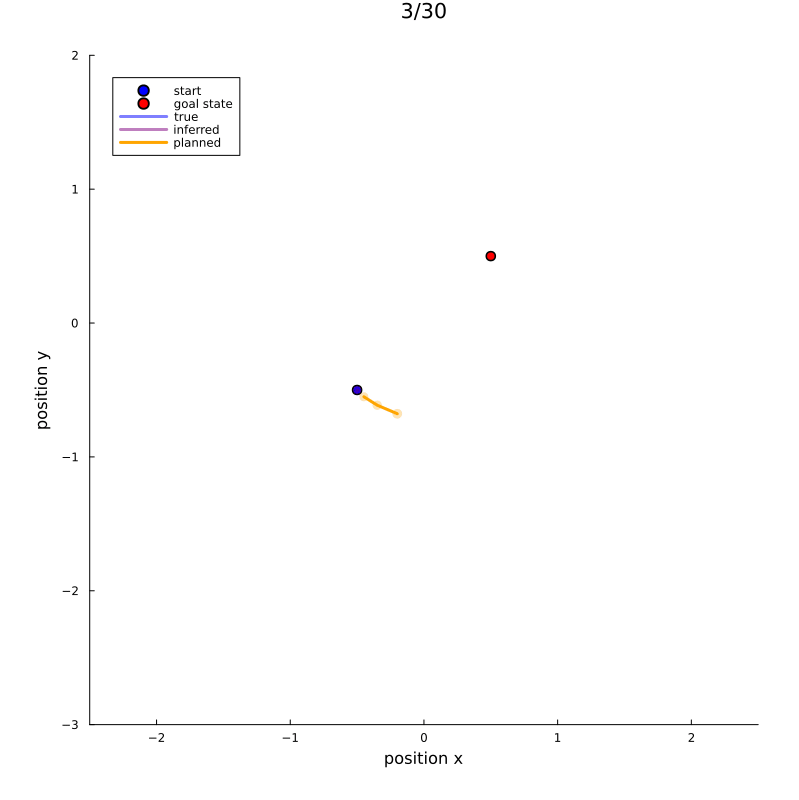

In [267]:
anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), title="$k/$len_trial", legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=(-2.5, 2.5), ylims=(-3., 2.))
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)    
    
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
    covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)

    plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
    for j in 1:len_horizon
        covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
    end
end
gif(anim, "figures/experiment-EFE-path+planning.gif", fps=3) 

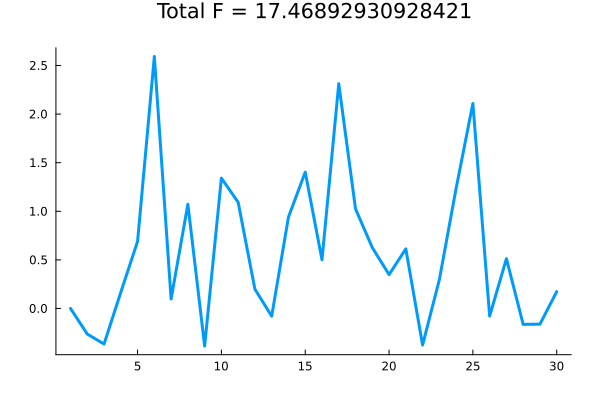

In [268]:
tF = sum(F)
plot(F, title="Total F = $tF")

### Baseline: MPC

In [269]:
function QCR(u::AbstractVector, 
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Vector{Float64}; 
             η_u::Float64=1.0,
             time_horizon::Int64=1)
    "Linear-Quadratic Gaussian control"
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cJ = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        m_t = A*m_tmin1 + B*u[(t-1)*2+1:2t]
        S_t = A*S_kmin1*A' .+ Q
        
        # Unscented transform moments
        μ, Σ, Γ = ET2(m_t, S_t, g, addmatrix=R, forceHermitian=true)
        
        # Cumulate EFE
        cJ += (μ - goal)'*(μ - goal) + η_u*u[(t-1)*2+1:2t]'*u[(t-1)*2+1:2t]
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cJ
end

QCR (generic function with 1 method)

In [270]:
# Preallocate
z_est = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim = zeros(4,len_trial)
y_sim = zeros(2,len_trial)
u_sim = zeros(2,len_trial)
F = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

# Initialize policy
policy = zeros(2len_horizon)

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[:,k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[:,k-1]
    S_k_pred = A*S_kmin1*A' .+ Q
    
    # Correction step
    μ, Σ, Γ = ET2(m_k_pred, S_k_pred, g, addmatrix=R, forceHermitian=true)
    m_k = m_k_pred .+ Γ*inv(Σ)*(y_sim[:,k] - μ)
    S_k = S_k_pred .- Γ*inv(Σ)*Γ'
    
    # Compute model evidence
    F[k] = evidence(y_sim[:,k], m_k, S_k)
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    J(u::AbstractVector) = QCR(u, (m_k,S_k), goal[1], η_u=η_u, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(J, u_lims[1], u_lims[2], zeros(2len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    # results = Optim.optimize(J, zeros(2*len_horizon), LBFGS(), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = reshape(Optim.minimizer(results), (2,len_horizon))
    
    # Planning
    planned_states, planned_obs = planned_trajectory(policy, (m_k,S_k), time_horizon=len_horizon)
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
    
    # Execute first planned action only
    u_sim[:,k] = policy[:,1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


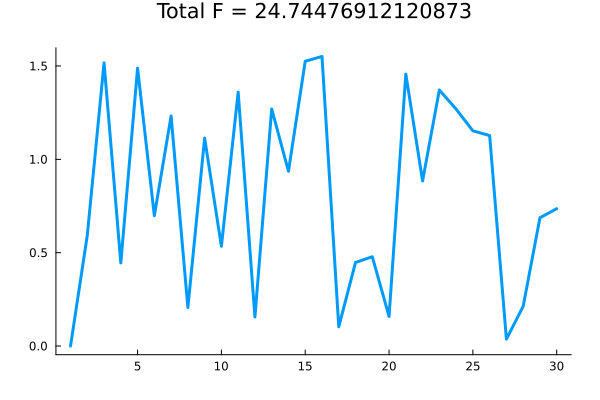

In [271]:
tF = sum(F)
plot(F, title="Total F = $tF")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/experiment-QCR-path+planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/IWAI2024-ambiguity/figures/experiment-QCR-path+planning.gif")
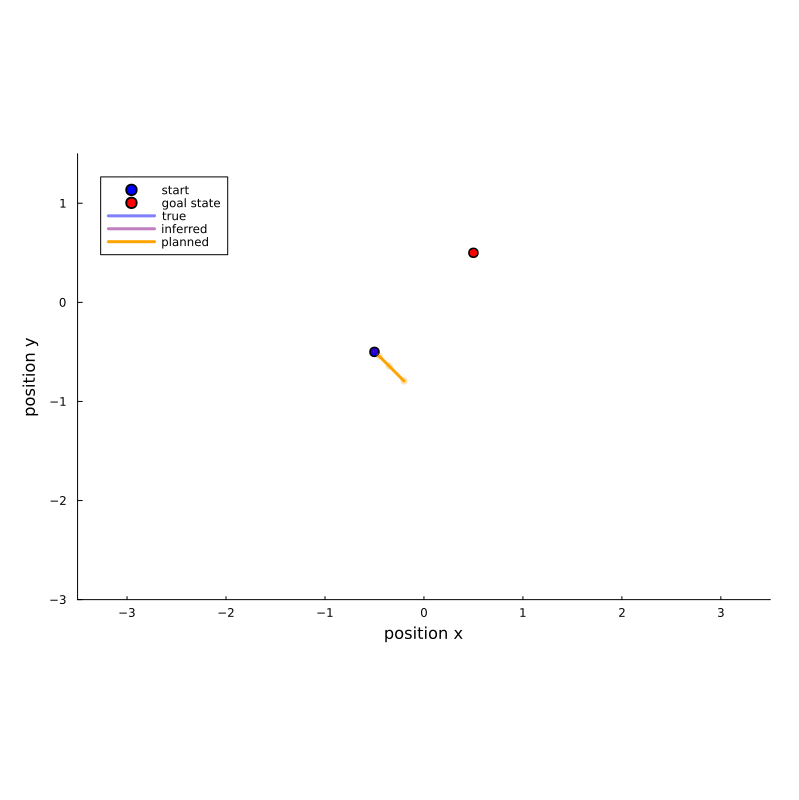

In [272]:
anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=(-3.5, 3.5), ylims=(-3., 1.5))
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
    covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)
    
    plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
    for j in 1:len_horizon
        covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
    end
end
gif(anim, "figures/experiment-QCR-path+planning.gif", fps=3) 

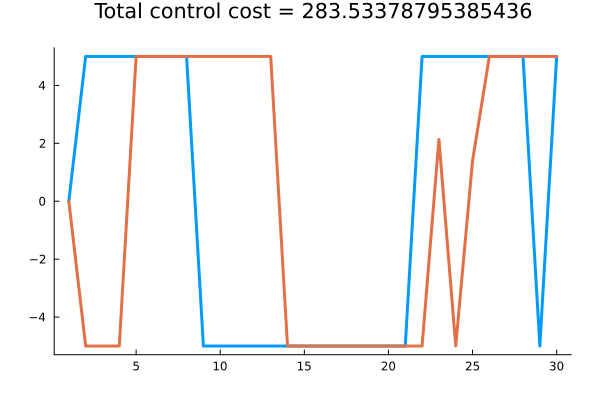

In [273]:
tU = sum(abs.(u_sim[:]))
plot(u_sim', title="Total control cost = $tU")